# NLP Application with ML

## Classification of Tweets Data

### The Data

Source: https://www.kaggle.com/crowdflower/twitter-airline-sentiment?select=Tweets.csv

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from collections import Counter   # tokenleri saymak için
import warnings
warnings.filterwarnings("ignore")
plt.rcParams["figure.figsize"] = (10,6)
pd.set_option('display.max_columns', 50)

In [2]:
df = pd.read_csv("airline_tweets.csv")
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


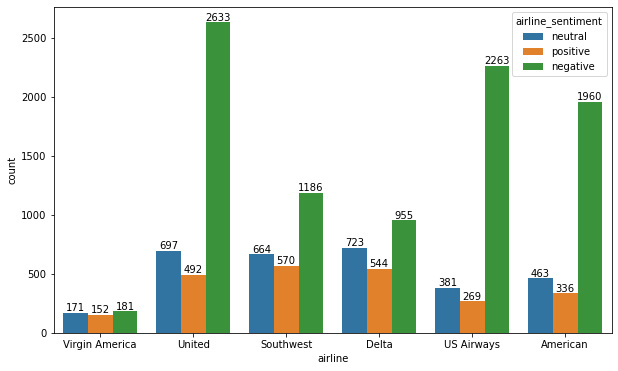

In [3]:
ax = sns.countplot(x ="airline", hue = "airline_sentiment", data = df)
for p in ax.containers:
    ax.bar_label(p)

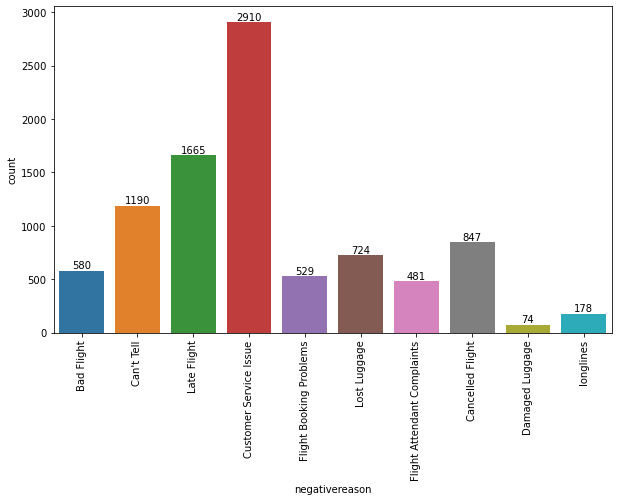

In [4]:
ax = sns.countplot(data =df, x ="negativereason")
ax.bar_label(ax.containers[0])
plt.xticks(rotation =90);

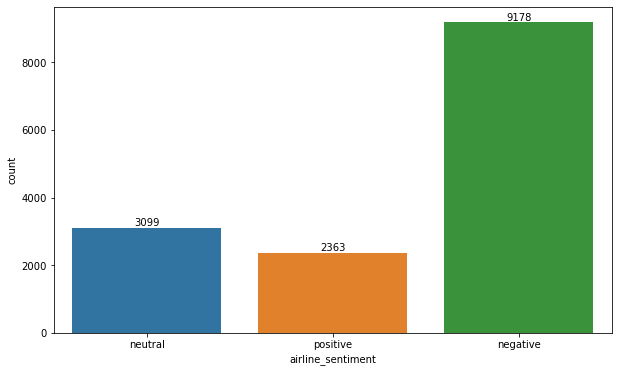

In [5]:
ax = sns.countplot(data =df, x = "airline_sentiment")
ax.bar_label(ax.containers[0]);

In [6]:
df["airline_sentiment"].value_counts()

negative    9178
neutral     3099
positive    2363
Name: airline_sentiment, dtype: int64

## Cleaning Data

NLP de missing value durumu söz konusu ise bunları doldurmak için uğraşmıyoruz. Ancak az olan labela yönelik yorumları artırma yöntemleri mevcut.

In [7]:
df2 = df.copy()

In [8]:
df2["text"].head()

0                  @VirginAmerica What @dhepburn said.
1    @VirginAmerica plus you've added commercials t...
2    @VirginAmerica I didn't today... Must mean I n...
3    @VirginAmerica it's really aggressive to blast...
4    @VirginAmerica and it's a really big bad thing...
Name: text, dtype: object

## Cleaning Data

re.sub("http\S+", "", s)  http\ den sonra boşluğa kadar olan kısmı temizledi ve bunun yerine birşey getirmedi. Hangi string ifadeye uğrayacaksak içine onu yazdık(s)

strip ise cümlenin başındaki ve sonundaki boşlukları alıyor." #lateflight @airlines" ifadesinin başındaki boşluğa kaldırmış oldu.

In [9]:
import re
s = "http\\:www.mynet.com #lateflight @airlines"
s = re.sub("http\S+", "", s).strip()  
# S: boşluk haric bütün diğer karakterler 
# +: en az 1 ve daha fazla
# strip() ile de boşluğu alıyoruz.
s

'#lateflight @airlines'

In [10]:
s = re.sub("#\S+", "", s)
s

' @airlines'

In [11]:
s = re.sub("@\S+", "", s)
s.strip()

''

In [12]:
#nltk.download('stopwords')

In [13]:
#nltk.download('wordnet')

!!! Önemli:

Sentiment analiz yaptığımızdan dolayı not ve no ları stopwords içinden çıkardık.

Aşağıda ise sırasıyla önce url, sonra tag sonra da mentionları kaldırdık.

In [14]:
stop_words = stopwords.words('english')

for i in ["not", "no"]:
        stop_words.remove(i)

In [15]:
def cleaning(data):
    
    import re
    
    # 1. Removing URLS
    data = re.sub('http\S+', '', data).strip()
    data = re.sub('www\S+', '', data).strip()

    # 2. Removing Tags
    data = re.sub('#\S+', '', data).strip()

    # 3. Removing Mentions
    data = re.sub('@\S+', '', data).strip()
    
    # 4. Removing upper brackets to keep negative auxiliary verbs in text
    data = data.replace("'", "")
    
    # 5. Tokenize
    text_tokens = word_tokenize(data.lower())
    
    # 6. Remove Puncs and number
    tokens_without_punc = [w for w in text_tokens if w.isalpha()]
    
    # 7. Removing Stopwords
    tokens_without_sw = [t for t in tokens_without_punc if t not in stop_words]
    
    # 8. lemma
    text_cleaned = [WordNetLemmatizer().lemmatize(t) for t in tokens_without_sw]
    
    #joining
    return " ".join(text_cleaned)

In [16]:
cleaning_text = df2["text"].apply(cleaning)
cleaning_text.head()

0                                                 said
1         plus youve added commercial experience tacky
2         didnt today must mean need take another trip
3    really aggressive blast obnoxious entertainmen...
4                                 really big bad thing
Name: text, dtype: object

## Features and Label

Yukarıdaki gibi manuel olarak yaptığımız temizleme işlemini aşağıdaki gibi vectorize func. içinde bir parametre kullanarak yapacağımdan dolayı texti tekrar aldım.

In [17]:
df2 =df2[["airline_sentiment", "text"]]
df2.head()

,airline_sentiment,text
0,neutral,@VirginAmerica What @dhepburn said.
1,positive,@VirginAmerica plus you've added commercials t...
2,neutral,@VirginAmerica I didn't today... Must mean I n...
3,negative,@VirginAmerica it's really aggressive to blast...
4,negative,@VirginAmerica and it's a really big bad thing...


## Train Test Split

In [18]:
from sklearn.model_selection import train_test_split

Aşağıda temizlenmemiş veri setini kullandığımıza dikkat edelim.

In [19]:
X = df2["text"]
y= df2["airline_sentiment"]

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=101)

## Vectorization

In [21]:
from sklearn.feature_extraction.text import CountVectorizer

!!! ÖNEMLİ:

Preprocessor=cleaning karşısına bu şekilde yukarıda tanımladığım func. ismini yazınca bu işlemi kendisi otomatik olarak yapıyor. 

min_df ise benim corpus ta 3 veya daha az geçen tokenleri ignore ediyor. Bunları sayısallaştırmıyor.

max_feature ise corpus içinde en fazla geçen ilk 1500 tokeni kullan demek. max_feature kullanmak riskli. Eğitime daha çok katkısı olanları değil de en az katkısı olanları yani min_df kullanmak daha uygun bir davranış olur.

ngram_range ile modeldeki kalıpları öğrenmeye çalışır. 1,2 yazınca önce her bir kelimeyi teker teker alır ve bunlar ayrı birer feature olur. Sonra 2 şerli alır ve bunlarda ayrı birer feature olurlar. didnt like, dont like gibi kalıpları yakalamaya yarar ancak maliyetleri artırır. Her modelde fayda sağladığını söyleyemeyiz. Genellikle 1,2 ancak istisna olarak 1,3 seçilir. Default 1,1 dir. 1,3 yazınca 1,2,3 yani aradaki değeri de alır.

In [22]:
vectorizer = CountVectorizer(preprocessor=cleaning, min_df=3) # ngram_range=(1,2), max_features= 1500
X_train_count = vectorizer.fit_transform(X_train)
X_test_count = vectorizer.transform(X_test)

In [23]:
X_train_count.toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [25]:
pd.DataFrame(X_train_count.toarray(), columns = vectorizer.get_feature_names())

,aa,aadvantage,abc,ability,able,aboard,abq,absolute,absolutely,absurd,abt,abysmal,ac,accept,acceptable,accepted,accepting,access,accident,accommodate,accommodating,accommodation,accomplished,according,accordingly,...,yea,yeah,year,yell,yelled,yelling,yep,yes,yest,yesterday,yet,yo,york,youd,youll,young,youre,youve,yr,yuma,yup,yvr,yyz,zero,zone
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11707,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
11708,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
11709,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
11710,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Mesela burada feature importance kullanamazken, PCA kullanarak feature sayısını düşürebiliriz.

## Model Comparisons - Vectorization

In [26]:
from sklearn.metrics import confusion_matrix, classification_report, f1_score, recall_score

In [27]:
def eval(model, X_train, X_test):
    y_pred = model.predict(X_test)
    y_pred_train = model.predict(X_train)
    print(confusion_matrix(y_test, y_pred))
    print("Test_Set")
    print(classification_report(y_test,y_pred))
    print("Train_Set")
    print(classification_report(y_train,y_pred_train))
    

## Naive Bayes

!!! Çok Önemli:

Naive Bayes daha çok DL modelleri ile kullanılır. Çok iyi sonuçlar verdiğinden dolayı NLP de Naive Bayes kullanılması tavsiye ediliyor. Burada bunu P(A|B) yani A given B olarak düşünebiliriz. Bu durumda B verilince A olma olasılığı. Mesela don't like birlikte kullanıldığında yorumun negatif olma olasılığı gibi.

Naive Bayes de kullanılan algoritmalar; 
MultinominalNB, multiclass modellerde, 
BernoulliNB ise binary kullanılır ancak documenda ikiside kullanılıp hangisi daha iyi score veriyorsa onun ile devam edilmesi tavsiye ediliyor.

alpha parametresi ise; mesela able kelimesinin corpus içinde geçmemesi durumunda sonucun yani P(pozitif|able) 0/0 olarak gelmesini engellemek için alpha değeri kadar bir değer vererek bir log yani olasılık hesaplamasını sağlıyoruz. 0 olmasada ona yakın bir değer vermiş oluyor. Burada Naive Bayes modellerimin overfitting gitmesini engelliyor. Lasso ve Riched de olduğu gibi alpha değeri ne kadar büyürse uyguladığı regresyon işlemi o kadar fazla oluyor. Eger bir overfitting ile karşılaşırsak burada yapmamız gereken alpha değerini büyütmek olacaktır.

In [28]:
from sklearn.naive_bayes import MultinomialNB, BernoulliNB # BernoulliNB for binary model

In [29]:
nb = MultinomialNB(alpha=3)
nb.fit(X_train_count, y_train)

MultinomialNB(alpha=3)

Burada negative scorelara yoğunlaştığımızdan dolayı alpha değerini 1 yerine 3 alınca aşağıdaki negative değerlerinin birbirine yaklaştığını gördük. 

CV ile aldığımız scoreları teyit etmiş olduk. 

Daha sonra datam dengesiz olduğundan dolayı PrecissionRecallCurve sonucuna baktık. 

In [30]:
print("NB MODEL")
eval(nb, X_train_count, X_test_count)

NB MODEL
[[1706   86   44]
 [ 336  239   45]
 [ 141   35  296]]
Test_Set
              precision    recall  f1-score   support

    negative       0.78      0.93      0.85      1836
     neutral       0.66      0.39      0.49       620
    positive       0.77      0.63      0.69       472

    accuracy                           0.77      2928
   macro avg       0.74      0.65      0.68      2928
weighted avg       0.75      0.77      0.75      2928

Train_Set
              precision    recall  f1-score   support

    negative       0.81      0.94      0.87      7342
     neutral       0.75      0.49      0.59      2479
    positive       0.81      0.67      0.74      1891

    accuracy                           0.80     11712
   macro avg       0.79      0.70      0.73     11712
weighted avg       0.80      0.80      0.79     11712



In [31]:
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score
scoring = {'accuracy': make_scorer(accuracy_score),
            'precision-neg': make_scorer(precision_score, average=None, labels=["negative"]),
            'recall-neg': make_scorer(recall_score, average=None, labels = ["negative"]),
            'f1-neg': make_scorer(f1_score, average=None, labels = ["negative"])}

model = MultinomialNB(alpha=3)
scores = cross_validate(model, X_train_count, y_train, scoring = scoring, cv = 10)
df_scores = pd.DataFrame(scores, index = range(1, 11))
df_scores.mean()[2:]

test_accuracy         0.755634
test_precision-neg    0.776940
test_recall-neg       0.924133
test_f1-neg           0.844162
dtype: float64

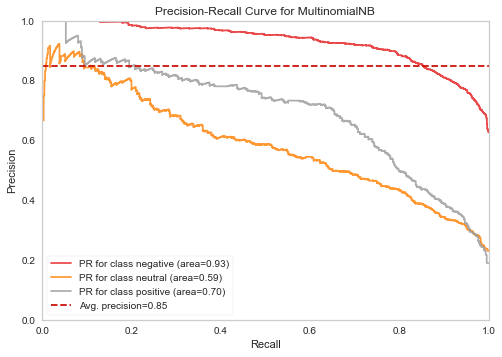

In [32]:
from yellowbrick.classifier import PrecisionRecallCurve

viz = PrecisionRecallCurve(
    MultinomialNB(alpha=3),
    classes=nb.classes_,  # class isimlerini yazdık.
    per_class=True,
    cmap="Set1"
)
viz.fit(X_train_count,y_train)
viz.score(X_test_count, y_test)
viz.show();

In [33]:
y_pred = nb.predict(X_test_count)
nb_count_rec_neg = recall_score(y_test, y_pred, labels = ["negative"], average = None)
nb_count_f1_neg = f1_score(y_test, y_pred, labels = ["negative"], average = None)
nb_AP_neg = viz.score_["negative"]

## Logistic Regression

Model overfitting gittiğinden dolayı burada C kullandık. C değerinde ise küçüldükçe regresyon kuvveti artıyor. Overfitting üstesinden daha iyi geldiğini C değerini deneyerek gördük. 

max_iter artırmamız yönünde uyarı verdiğinden dolayı bu değeri aldık.

In [34]:
from sklearn.linear_model import LogisticRegression
log = LogisticRegression(C = 0.02, max_iter=1000) #class_weight='balanced'
log.fit(X_train_count,y_train)

LogisticRegression(C=0.02, max_iter=1000)

In [35]:
print("LOG MODEL")
eval(log, X_train_count, X_test_count)

LOG MODEL
[[1760   40   36]
 [ 366  211   43]
 [ 177   47  248]]
Test_Set
              precision    recall  f1-score   support

    negative       0.76      0.96      0.85      1836
     neutral       0.71      0.34      0.46       620
    positive       0.76      0.53      0.62       472

    accuracy                           0.76      2928
   macro avg       0.74      0.61      0.64      2928
weighted avg       0.75      0.76      0.73      2928

Train_Set
              precision    recall  f1-score   support

    negative       0.77      0.97      0.86      7342
     neutral       0.76      0.41      0.53      2479
    positive       0.79      0.51      0.62      1891

    accuracy                           0.77     11712
   macro avg       0.77      0.63      0.67     11712
weighted avg       0.77      0.77      0.75     11712



In [36]:
model = LogisticRegression(C = 0.02, max_iter=1000)
scores = cross_validate(model, X_train_count, y_train, scoring = scoring, cv = 10)
df_scores = pd.DataFrame(scores, index = range(1, 11))
df_scores.mean()[2:]

test_accuracy         0.744277
test_precision-neg    0.746718
test_recall-neg       0.963361
test_f1-neg           0.841295
dtype: float64

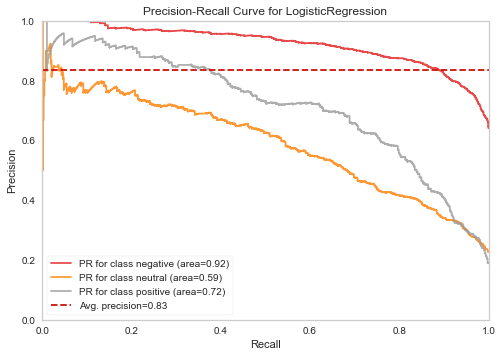

In [37]:
viz = PrecisionRecallCurve(
    LogisticRegression(C = 0.02, max_iter=1000),
    classes=log.classes_,
    per_class=True,
    cmap="Set1"
)
viz.fit(X_train_count,y_train)
viz.score(X_test_count, y_test)
viz.show();

In [38]:
y_pred = log.predict(X_test_count)
log_count_rec_neg = recall_score(y_test, y_pred, labels = ["negative"], average = None)
log_count_f1_neg = f1_score(y_test, y_pred, labels = ["negative"], average = None)
log_AP_neg = viz.score_["negative"]

In [39]:
log = LogisticRegression(C = 0.02, max_iter=1000, class_weight='balanced')
log.fit(X_train_count,y_train)

LogisticRegression(C=0.02, class_weight='balanced', max_iter=1000)

Bizim için negatif scorelar önemli ancak burada pozitif scorelarıda görmek isteyebiliriz. Bu durumda; LogReg de class_weight balanced ile de score alıyoruz ve positive değerleride yakaladığını görüyoruz.

In [40]:
print("LOG MODEL BALANCED")
eval(log, X_train_count, X_test_count)

LOG MODEL BALANCED
[[1305  434   97]
 [  98  447   75]
 [  34   96  342]]
Test_Set
              precision    recall  f1-score   support

    negative       0.91      0.71      0.80      1836
     neutral       0.46      0.72      0.56       620
    positive       0.67      0.72      0.69       472

    accuracy                           0.72      2928
   macro avg       0.68      0.72      0.68      2928
weighted avg       0.77      0.72      0.73      2928

Train_Set
              precision    recall  f1-score   support

    negative       0.93      0.74      0.82      7342
     neutral       0.51      0.78      0.62      2479
    positive       0.67      0.75      0.71      1891

    accuracy                           0.75     11712
   macro avg       0.70      0.75      0.72     11712
weighted avg       0.80      0.75      0.76     11712



## SVM

Burada default değer üzerinden score alınca train ve test seti arasında bir uçurum olduğunu yani overfitting olduğunu görüyoruz. Bunun üzerinden gelmek için C yi düşürüyoruz. Daha sonra overfitting üstesinden geldiğimizi görüyoruz. 

CV ile de aldığımız scoreları kontrol ettik.

In [41]:
from sklearn.svm import LinearSVC
svc = LinearSVC(C=0.01)
svc.fit(X_train_count,y_train)

LinearSVC(C=0.01)

In [42]:
print("SVC MODEL")
eval(svc, X_train_count, X_test_count)

SVC MODEL
[[1712   80   44]
 [ 291  278   51]
 [ 124   50  298]]
Test_Set
              precision    recall  f1-score   support

    negative       0.80      0.93      0.86      1836
     neutral       0.68      0.45      0.54       620
    positive       0.76      0.63      0.69       472

    accuracy                           0.78      2928
   macro avg       0.75      0.67      0.70      2928
weighted avg       0.77      0.78      0.77      2928

Train_Set
              precision    recall  f1-score   support

    negative       0.83      0.95      0.89      7342
     neutral       0.76      0.55      0.64      2479
    positive       0.80      0.63      0.70      1891

    accuracy                           0.82     11712
   macro avg       0.80      0.71      0.74     11712
weighted avg       0.81      0.82      0.81     11712



In [43]:
model = LinearSVC(C=0.01)
scores = cross_validate(model, X_train_count, y_train, scoring = scoring, cv = 10)
df_scores = pd.DataFrame(scores, index = range(1, 11))
df_scores.mean()[2:]

test_accuracy         0.776724
test_precision-neg    0.800174
test_recall-neg       0.936802
test_f1-neg           0.863100
dtype: float64

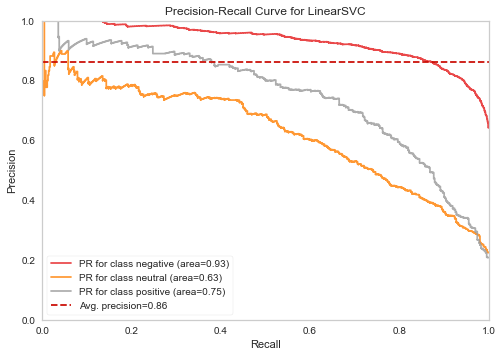

In [44]:
viz = PrecisionRecallCurve(
    LinearSVC(C=0.01),
    classes=svc.classes_,
    per_class=True,
    cmap="Set1"
)
viz.fit(X_train_count,y_train)
viz.score(X_test_count, y_test)
viz.show();

In [45]:
y_pred = svc.predict(X_test_count)
svc_count_rec_neg = recall_score(y_test, y_pred, labels = ["negative"], average = None)
svc_count_f1_neg = f1_score(y_test, y_pred, labels = ["negative"], average = None)
svc_AP_neg = viz.score_["negative"]

## KNN

KNN burada elbow metodu ile kullanırsak çok uzun zaman alacaktır. Bundan dolayı burada n_neighbors deneyerek bulduk. 

Scoreların çok kötü olduğunu CV ile de teyit ettik. 

In [46]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=7)
knn.fit(X_train_count,y_train)

KNeighborsClassifier(n_neighbors=7)

In [47]:
print("KNN MODEL")
eval(knn, X_train_count, X_test_count)

KNN MODEL
[[913 839  84]
 [103 457  60]
 [ 44 170 258]]
Test_Set
              precision    recall  f1-score   support

    negative       0.86      0.50      0.63      1836
     neutral       0.31      0.74      0.44       620
    positive       0.64      0.55      0.59       472

    accuracy                           0.56      2928
   macro avg       0.60      0.59      0.55      2928
weighted avg       0.71      0.56      0.58      2928

Train_Set
              precision    recall  f1-score   support

    negative       0.90      0.62      0.74      7342
     neutral       0.40      0.82      0.53      2479
    positive       0.69      0.55      0.61      1891

    accuracy                           0.65     11712
   macro avg       0.66      0.66      0.63     11712
weighted avg       0.76      0.65      0.67     11712



In [48]:
model = KNeighborsClassifier(n_neighbors=7)
scores = cross_validate(model, X_train_count, y_train, scoring = scoring, cv = 10)
df_scores = pd.DataFrame(scores, index = range(1, 11))
df_scores.mean()[2:]

test_accuracy         0.535347
test_precision-neg    0.850132
test_recall-neg       0.468129
test_f1-neg           0.603456
dtype: float64

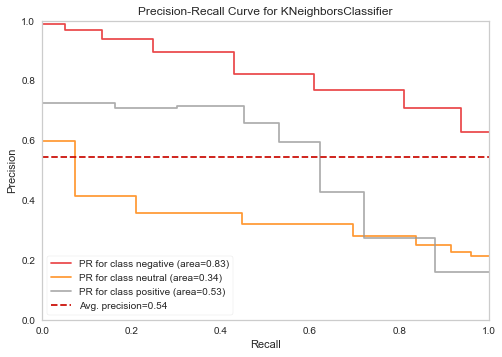

In [49]:
viz = PrecisionRecallCurve(
    KNeighborsClassifier(n_neighbors=7),
    classes=knn.classes_,
    per_class=True,
    cmap="Set1"
)
viz.fit(X_train_count,y_train)
viz.score(X_test_count, y_test)
viz.show();

In [50]:
y_pred = knn.predict(X_test_count)
knn_count_rec_neg = recall_score(y_test, y_pred, labels = ["negative"], average = None)
knn_count_f1_neg = f1_score(y_test, y_pred, labels = ["negative"], average = None)
knn_AP_neg = viz.score_["negative"]

## Random Forest

!!! Önemli:

GridSearch yapmadan overfitting ile mücadele etmede en önemli unsur olduğundan dolayı direkt olarak max_depth değeri ile oynadık. Azalttığımız zaman daha iyi scorelar verdiğini gördük. 40 değeri için negatif değerlerde ovetfitting üzerinden geldiğini gördük.

NLP de ML modelleri çok fazla tercih edilmez. Daha çok BERT kullanacağız. Ancak bazı data setlerinde ML ile daha iyi scorelar alabiliriz. DL modelleride kullanılmaktadır.

NLP de en önemli sorun classification ve sentiment analiz kısımlarıdır. BERT modellerinde tuning olayı çok fazla bilinmemektedir.

RF ile aldığımız scoreların negatif değerler için iyi olduğunu gördük. Ancak balanced ile pozitif değerler için iyi scorelar alamadığımızı gördük.

In [51]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(100, max_depth = 40, random_state = 42, n_jobs = -1) # class_weight="balanced"
rf.fit(X_train_count, y_train)

RandomForestClassifier(max_depth=40, n_jobs=-1, random_state=42)

In [52]:
print("RF MODEL")
eval(rf, X_train_count, X_test_count)

RF MODEL
[[1805   11   20]
 [ 526   61   33]
 [ 232    6  234]]
Test_Set
              precision    recall  f1-score   support

    negative       0.70      0.98      0.82      1836
     neutral       0.78      0.10      0.17       620
    positive       0.82      0.50      0.62       472

    accuracy                           0.72      2928
   macro avg       0.77      0.53      0.54      2928
weighted avg       0.74      0.72      0.65      2928

Train_Set
              precision    recall  f1-score   support

    negative       0.74      1.00      0.85      7342
     neutral       0.98      0.21      0.34      2479
    positive       0.94      0.62      0.74      1891

    accuracy                           0.77     11712
   macro avg       0.88      0.61      0.64     11712
weighted avg       0.82      0.77      0.72     11712



In [53]:
model = RandomForestClassifier(100, max_depth = 40, random_state = 42, n_jobs = -1)
scores = cross_validate(model, X_train_count, y_train, scoring = scoring, cv = 10)
df_scores = pd.DataFrame(scores, index = range(1, 11))
df_scores.mean()[2:]

test_accuracy         0.709442
test_precision-neg    0.697297
test_recall-neg       0.985017
test_f1-neg           0.816541
dtype: float64

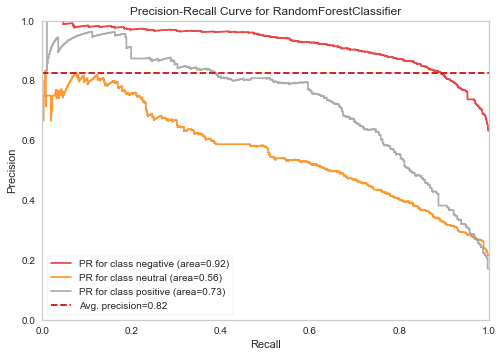

In [54]:
viz = PrecisionRecallCurve(
    RandomForestClassifier(100, max_depth = 40, random_state = 42, n_jobs = -1),
    classes=rf.classes_,
    per_class=True,
    cmap="Set1"
)
viz.fit(X_train_count,y_train)
viz.score(X_test_count, y_test)
viz.show();

In [55]:
y_pred = rf.predict(X_test_count)
rf_count_rec_neg = recall_score(y_test, y_pred, labels = ["negative"], average = None)
rf_count_f1_neg = f1_score(y_test, y_pred, labels = ["negative"], average = None)
rf_AP_neg = viz.score_["negative"]

In [56]:
rf = RandomForestClassifier(100, max_depth = 40, random_state = 42, n_jobs = -1, class_weight="balanced")
rf.fit(X_train_count, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=40, n_jobs=-1,
                       random_state=42)

In [57]:
print("RF MODEL BALANCED")
eval(rf, X_train_count, X_test_count)

RF MODEL BALANCED
[[1485  278   73]
 [ 163  398   59]
 [  61   96  315]]
Test_Set
              precision    recall  f1-score   support

    negative       0.87      0.81      0.84      1836
     neutral       0.52      0.64      0.57       620
    positive       0.70      0.67      0.69       472

    accuracy                           0.75      2928
   macro avg       0.70      0.71      0.70      2928
weighted avg       0.77      0.75      0.76      2928

Train_Set
              precision    recall  f1-score   support

    negative       0.98      0.86      0.91      7342
     neutral       0.65      0.92      0.76      2479
    positive       0.89      0.82      0.85      1891

    accuracy                           0.86     11712
   macro avg       0.84      0.86      0.84     11712
weighted avg       0.89      0.86      0.87     11712



## Ada Boost

n_estimators=500 için aldığımız scoreların birbirine yaklaştığını gördük. 

CV ile de scoreları teyit ettik.

In [58]:
from sklearn.ensemble import AdaBoostClassifier
ada = AdaBoostClassifier(n_estimators= 500, random_state = 42)
ada.fit(X_train_count, y_train)

AdaBoostClassifier(n_estimators=500, random_state=42)

In [59]:
print("Ada MODEL")
eval(ada, X_train_count, X_test_count)

Ada MODEL
[[1566  203   67]
 [ 207  340   73]
 [  82   74  316]]
Test_Set
              precision    recall  f1-score   support

    negative       0.84      0.85      0.85      1836
     neutral       0.55      0.55      0.55       620
    positive       0.69      0.67      0.68       472

    accuracy                           0.76      2928
   macro avg       0.70      0.69      0.69      2928
weighted avg       0.76      0.76      0.76      2928

Train_Set
              precision    recall  f1-score   support

    negative       0.87      0.88      0.87      7342
     neutral       0.61      0.62      0.62      2479
    positive       0.78      0.70      0.74      1891

    accuracy                           0.80     11712
   macro avg       0.75      0.74      0.74     11712
weighted avg       0.80      0.80      0.80     11712



In [60]:
model = AdaBoostClassifier(n_estimators= 500, random_state = 42)
scores = cross_validate(model, X_train_count, y_train, scoring = scoring, cv = 10)
df_scores = pd.DataFrame(scores, index = range(1, 11))
df_scores.mean()[2:]

test_accuracy         0.757258
test_precision-neg    0.846478
test_recall-neg       0.851264
test_f1-neg           0.848807
dtype: float64

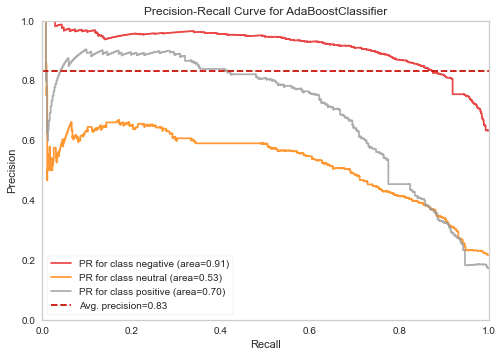

In [61]:
viz = PrecisionRecallCurve(
    AdaBoostClassifier(n_estimators= 500, random_state = 42),
    classes=ada.classes_,
    per_class=True,
    cmap="Set1"
)
viz.fit(X_train_count,y_train)
viz.score(X_test_count, y_test)
viz.show();

In [62]:
y_pred = ada.predict(X_test_count)
ada_count_rec_neg = recall_score(y_test, y_pred, labels = ["negative"], average = None)
ada_count_f1_neg = f1_score(y_test, y_pred, labels = ["negative"], average = None)
ada_AP_neg = viz.score_["negative"]

## TF-IDF

Yukarıda countvectorize sonucu oluşturduğumuz texti ML modelleri ile kullandık. Şimdi ayni işlemi TF/IDF sonucu aldığımız text için kullanacağız.

In [63]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [64]:
tf_idf_vectorizer = TfidfVectorizer(preprocessor=cleaning, min_df=3)
X_train_tf_idf = tf_idf_vectorizer.fit_transform(X_train)
X_test_tf_idf = tf_idf_vectorizer.transform(X_test)

In [65]:
X_train_tf_idf.toarray()

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.32545156, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [67]:
pd.DataFrame(X_train_tf_idf.toarray(), columns = tf_idf_vectorizer.get_feature_names())

,aa,aadvantage,abc,ability,able,aboard,abq,absolute,absolutely,absurd,abt,abysmal,ac,accept,acceptable,accepted,accepting,access,accident,accommodate,accommodating,accommodation,accomplished,according,accordingly,...,yea,yeah,year,yell,yelled,yelling,yep,yes,yest,yesterday,yet,yo,york,youd,youll,young,youre,youve,yr,yuma,yup,yvr,yyz,zero,zone
0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.335285,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11707,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11708,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11709,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11710,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Model Comparisons  TF-IDF

## Naive Bayes

Burada alpha değeri ile oynamadık çünkü default alpha=1 değeri negatifler için en iyi scoreları verdi bize. Bir overfitting durumu söz konusu değil. 

CV ile de scoreları teyit ettik. 

In [68]:
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
nb = MultinomialNB()
nb.fit(X_train_tf_idf, y_train)

MultinomialNB()

In [69]:
print("NB MODEL")
eval(nb, X_train_tf_idf, X_test_tf_idf)

NB MODEL
[[1803   25    8]
 [ 426  172   22]
 [ 247   31  194]]
Test_Set
              precision    recall  f1-score   support

    negative       0.73      0.98      0.84      1836
     neutral       0.75      0.28      0.41       620
    positive       0.87      0.41      0.56       472

    accuracy                           0.74      2928
   macro avg       0.78      0.56      0.60      2928
weighted avg       0.76      0.74      0.70      2928

Train_Set
              precision    recall  f1-score   support

    negative       0.75      0.99      0.85      7342
     neutral       0.84      0.35      0.50      2479
    positive       0.92      0.51      0.65      1891

    accuracy                           0.78     11712
   macro avg       0.84      0.62      0.67     11712
weighted avg       0.80      0.78      0.75     11712



In [70]:
model = MultinomialNB()
scores = cross_validate(model, X_train_tf_idf, y_train, scoring = scoring, cv = 10)
df_scores = pd.DataFrame(scores, index = range(1, 11))
df_scores.mean()[2:]

test_accuracy         0.731215
test_precision-neg    0.721762
test_recall-neg       0.978206
test_f1-neg           0.830625
dtype: float64

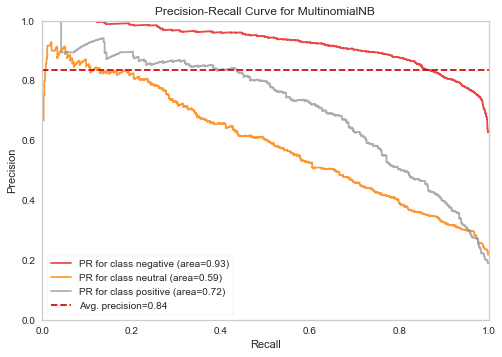

In [71]:
viz = PrecisionRecallCurve(
    MultinomialNB(),
    classes=nb.classes_,
    per_class=True,
    cmap="Set1"
)
viz.fit(X_train_tf_idf,y_train)
viz.score(X_test_tf_idf, y_test)
viz.show();

In [72]:
y_pred = nb.predict(X_test_tf_idf)
nb_tfidf_rec_neg = recall_score(y_test, y_pred, labels = ["negative"], average = None)
nb_tfidf_f1_neg = f1_score(y_test, y_pred, labels = ["negative"], average = None)
nb_tfidf_AP_neg = viz.score_["negative"]

## Logistic Regression

In [73]:
from sklearn.linear_model import LogisticRegression
log = LogisticRegression(C=0.4, max_iter=1000)
log.fit(X_train_tf_idf,y_train)

LogisticRegression(C=0.4, max_iter=1000)

In [74]:
print("LOG MODEL")
eval(log, X_train_tf_idf, X_test_tf_idf)

LOG MODEL
[[1758   51   27]
 [ 332  256   32]
 [ 144   47  281]]
Test_Set
              precision    recall  f1-score   support

    negative       0.79      0.96      0.86      1836
     neutral       0.72      0.41      0.53       620
    positive       0.83      0.60      0.69       472

    accuracy                           0.78      2928
   macro avg       0.78      0.66      0.69      2928
weighted avg       0.78      0.78      0.76      2928

Train_Set
              precision    recall  f1-score   support

    negative       0.82      0.97      0.89      7342
     neutral       0.82      0.53      0.64      2479
    positive       0.87      0.62      0.73      1891

    accuracy                           0.82     11712
   macro avg       0.84      0.71      0.75     11712
weighted avg       0.83      0.82      0.81     11712



In [75]:
model = LogisticRegression(C=0.4, max_iter=1000)
scores = cross_validate(model, X_train_tf_idf, y_train, scoring = scoring, cv = 10)
df_scores = pd.DataFrame(scores, index = range(1, 11))
df_scores.mean()[2:]

test_accuracy         0.769381
test_precision-neg    0.775030
test_recall-neg       0.960501
test_f1-neg           0.857827
dtype: float64

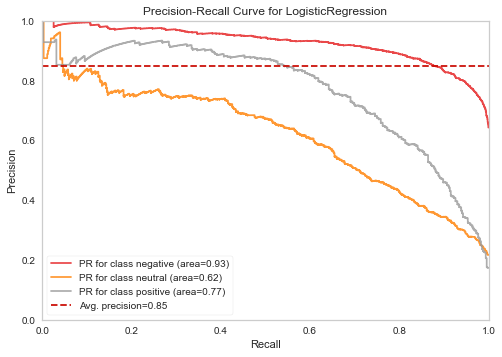

In [76]:
viz = PrecisionRecallCurve(
    LogisticRegression(C=0.4, max_iter=1000),
    classes=log.classes_,
    per_class=True,
    cmap="Set1"
)
viz.fit(X_train_tf_idf,y_train)
viz.score(X_test_tf_idf, y_test)
viz.show();

In [77]:
y_pred = log.predict(X_test_tf_idf)
log_tfidf_rec_neg = recall_score(y_test, y_pred, labels = ["negative"], average = None)
log_tfidf_f1_neg = f1_score(y_test, y_pred, labels = ["negative"], average = None)
log_tfidf_AP_neg = viz.score_["negative"]

In [78]:
log = LogisticRegression(C=0.4, max_iter=1000, class_weight="balanced")
log.fit(X_train_tf_idf,y_train)

LogisticRegression(C=0.4, class_weight='balanced', max_iter=1000)

In [79]:
print("LOG MODEL BALANCED")
eval(log, X_train_tf_idf, X_test_tf_idf)

LOG MODEL BALANCED
[[1433  304   99]
 [ 121  427   72]
 [  39   71  362]]
Test_Set
              precision    recall  f1-score   support

    negative       0.90      0.78      0.84      1836
     neutral       0.53      0.69      0.60       620
    positive       0.68      0.77      0.72       472

    accuracy                           0.76      2928
   macro avg       0.70      0.75      0.72      2928
weighted avg       0.79      0.76      0.77      2928

Train_Set
              precision    recall  f1-score   support

    negative       0.94      0.81      0.87      7342
     neutral       0.61      0.80      0.69      2479
    positive       0.74      0.84      0.79      1891

    accuracy                           0.81     11712
   macro avg       0.76      0.82      0.78     11712
weighted avg       0.84      0.81      0.82     11712



Yukarıdaki sonuçlara bakınca bizim için önemli olan hangisi ise onun değerlerini karşılaştırdığımızda parametreler ile biraz daha oynayarak daha iyi sonuçlar almaya çalışmamız gerekir.

## SVM

In [80]:
from sklearn.svm import LinearSVC
svc = LinearSVC(C=0.1)
svc.fit(X_train_tf_idf,y_train)

LinearSVC(C=0.1)

In [81]:
print("SVC MODEL")
eval(svc, X_train_tf_idf, X_test_tf_idf)

SVC MODEL
[[1739   64   33]
 [ 312  263   45]
 [ 123   44  305]]
Test_Set
              precision    recall  f1-score   support

    negative       0.80      0.95      0.87      1836
     neutral       0.71      0.42      0.53       620
    positive       0.80      0.65      0.71       472

    accuracy                           0.79      2928
   macro avg       0.77      0.67      0.70      2928
weighted avg       0.78      0.79      0.77      2928

Train_Set
              precision    recall  f1-score   support

    negative       0.84      0.97      0.90      7342
     neutral       0.83      0.56      0.67      2479
    positive       0.87      0.68      0.76      1891

    accuracy                           0.84     11712
   macro avg       0.84      0.74      0.78     11712
weighted avg       0.84      0.84      0.83     11712



In [82]:
model = LinearSVC(C=0.1)
scores = cross_validate(model, X_train_tf_idf, y_train, scoring = scoring, cv = 10)
df_scores = pd.DataFrame(scores, index = range(1, 11))
df_scores.mean()[2:]

test_accuracy         0.781079
test_precision-neg    0.790769
test_recall-neg       0.955054
test_f1-neg           0.865153
dtype: float64

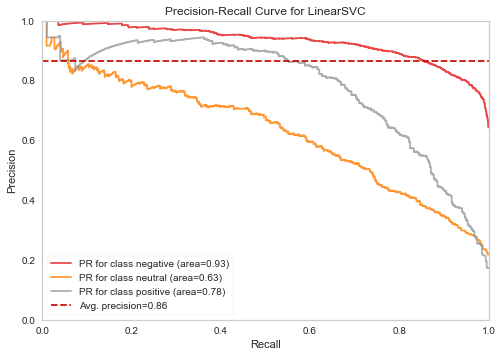

In [83]:
viz = PrecisionRecallCurve(
    LinearSVC(C=0.1),
    classes=svc.classes_,
    per_class=True,
    cmap="Set1"
)
viz.fit(X_train_tf_idf,y_train)
viz.score(X_test_tf_idf, y_test)
viz.show();

In [84]:
y_pred = svc.predict(X_test_tf_idf)
svc_tfidf_rec_neg = recall_score(y_test, y_pred, labels = ["negative"], average = None)
svc_tfidf_f1_neg = f1_score(y_test, y_pred, labels = ["negative"], average = None)
svc_tfidf_AP_neg = viz.score_["negative"]

## KNN

In [85]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=7)
knn.fit(X_train_tf_idf,y_train)

KNeighborsClassifier(n_neighbors=7)

In [86]:
print("KNN MODEL")
eval(knn, X_train_tf_idf, X_test_tf_idf)

KNN MODEL
[[ 270 1548   18]
 [  63  542   15]
 [  41  332   99]]
Test_Set
              precision    recall  f1-score   support

    negative       0.72      0.15      0.24      1836
     neutral       0.22      0.87      0.36       620
    positive       0.75      0.21      0.33       472

    accuracy                           0.31      2928
   macro avg       0.57      0.41      0.31      2928
weighted avg       0.62      0.31      0.28      2928

Train_Set
              precision    recall  f1-score   support

    negative       0.87      0.28      0.43      7342
     neutral       0.26      0.92      0.41      2479
    positive       0.82      0.25      0.38      1891

    accuracy                           0.41     11712
   macro avg       0.65      0.48      0.40     11712
weighted avg       0.73      0.41      0.42     11712



In [87]:
model = KNeighborsClassifier(n_neighbors=7)
scores = cross_validate(model, X_train_tf_idf, y_train, scoring = scoring, cv = 10)
df_scores = pd.DataFrame(scores, index = range(1, 11))
df_scores.mean()[2:]

test_accuracy         0.300374
test_precision-neg    0.721406
test_recall-neg       0.139742
test_f1-neg           0.233154
dtype: float64

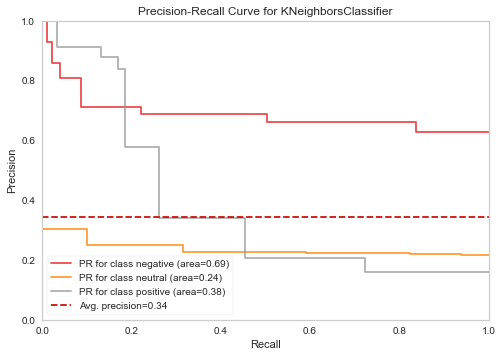

In [88]:
viz = PrecisionRecallCurve(
    KNeighborsClassifier(n_neighbors=7),
    classes=knn.classes_,
    per_class=True,
    cmap="Set1"
)
viz.fit(X_train_tf_idf,y_train)
viz.score(X_test_tf_idf, y_test)
viz.show();

In [89]:
y_pred = knn.predict(X_test_tf_idf)
knn_tfidf_rec_neg = recall_score(y_test, y_pred, labels = ["negative"], average = None)
knn_tfidf_f1_neg = f1_score(y_test, y_pred, labels = ["negative"], average = None)
knn_tfidf_AP_neg = viz.score_["negative"]

## RandomForest

In [90]:
rf = RandomForestClassifier(100, max_depth=40, random_state = 42, n_jobs = -1)
rf.fit(X_train_tf_idf, y_train)

RandomForestClassifier(max_depth=40, n_jobs=-1, random_state=42)

In [91]:
print("RF MODEL")
eval(rf, X_train_tf_idf, X_test_tf_idf)

RF MODEL
[[1814    8   14]
 [ 530   58   32]
 [ 252    5  215]]
Test_Set
              precision    recall  f1-score   support

    negative       0.70      0.99      0.82      1836
     neutral       0.82      0.09      0.17       620
    positive       0.82      0.46      0.59       472

    accuracy                           0.71      2928
   macro avg       0.78      0.51      0.52      2928
weighted avg       0.74      0.71      0.64      2928

Train_Set
              precision    recall  f1-score   support

    negative       0.73      1.00      0.84      7342
     neutral       0.98      0.21      0.34      2479
    positive       0.95      0.58      0.72      1891

    accuracy                           0.76     11712
   macro avg       0.88      0.60      0.63     11712
weighted avg       0.82      0.76      0.72     11712



In [92]:
model = RandomForestClassifier(100, max_depth=40, random_state = 42, n_jobs = -1)
scores = cross_validate(model, X_train_tf_idf, y_train, scoring = scoring, cv = 10)
df_scores = pd.DataFrame(scores, index = range(1, 11))
df_scores.mean()[2:]

test_accuracy         0.708675
test_precision-neg    0.695431
test_recall-neg       0.989649
test_f1-neg           0.816837
dtype: float64

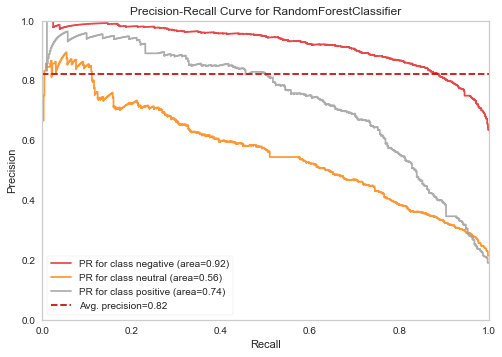

In [93]:
viz = PrecisionRecallCurve(
    RandomForestClassifier(100, max_depth=40, random_state = 42, n_jobs = -1),
    classes=rf.classes_,
    per_class=True,
    cmap="Set1"
)
viz.fit(X_train_tf_idf,y_train)
viz.score(X_test_tf_idf, y_test)
viz.show();

In [94]:
y_pred = rf.predict(X_test_tf_idf)
rf_tfidf_rec_neg = recall_score(y_test, y_pred, labels = ["negative"], average = None)
rf_tfidf_f1_neg = f1_score(y_test, y_pred, labels = ["negative"], average = None)
rf_tfidf_AP_neg = viz.score_["negative"]

In [95]:
rf = RandomForestClassifier(100, max_depth=15, random_state = 42, n_jobs = -1, class_weight="balanced")
rf.fit(X_train_tf_idf, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=15, n_jobs=-1,
                       random_state=42)

In [96]:
print("RF MODEL BALANCED")
eval(rf, X_train_tf_idf, X_test_tf_idf)

RF MODEL BALANCED
[[1360  383   93]
 [ 131  425   64]
 [  47  106  319]]
Test_Set
              precision    recall  f1-score   support

    negative       0.88      0.74      0.81      1836
     neutral       0.46      0.69      0.55       620
    positive       0.67      0.68      0.67       472

    accuracy                           0.72      2928
   macro avg       0.67      0.70      0.68      2928
weighted avg       0.76      0.72      0.73      2928

Train_Set
              precision    recall  f1-score   support

    negative       0.93      0.77      0.84      7342
     neutral       0.52      0.81      0.63      2479
    positive       0.75      0.71      0.73      1891

    accuracy                           0.77     11712
   macro avg       0.73      0.76      0.73     11712
weighted avg       0.81      0.77      0.78     11712



## Ada Boost

In [97]:
from sklearn.ensemble import AdaBoostClassifier
ada = AdaBoostClassifier(n_estimators= 500, random_state = 42)
ada.fit(X_train_tf_idf, y_train)

AdaBoostClassifier(n_estimators=500, random_state=42)

In [98]:
print("Ada MODEL")
eval(ada, X_train_tf_idf, X_test_tf_idf)

Ada MODEL
[[1547  217   72]
 [ 223  337   60]
 [  98   66  308]]
Test_Set
              precision    recall  f1-score   support

    negative       0.83      0.84      0.84      1836
     neutral       0.54      0.54      0.54       620
    positive       0.70      0.65      0.68       472

    accuracy                           0.75      2928
   macro avg       0.69      0.68      0.68      2928
weighted avg       0.75      0.75      0.75      2928

Train_Set
              precision    recall  f1-score   support

    negative       0.85      0.88      0.87      7342
     neutral       0.61      0.61      0.61      2479
    positive       0.82      0.72      0.77      1891

    accuracy                           0.80     11712
   macro avg       0.76      0.74      0.75     11712
weighted avg       0.80      0.80      0.80     11712



In [99]:
model = AdaBoostClassifier(n_estimators= 500, random_state = 42)
scores = cross_validate(model, X_train_tf_idf, y_train, scoring = scoring, cv = 10)
df_scores = pd.DataFrame(scores, index = range(1, 11))
df_scores.mean()[2:]

test_accuracy         0.739071
test_precision-neg    0.824649
test_recall-neg       0.843776
test_f1-neg           0.834057
dtype: float64

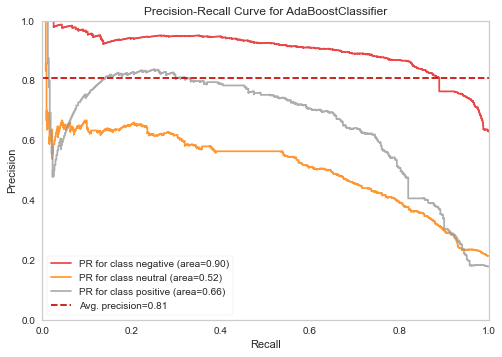

In [100]:
viz = PrecisionRecallCurve(
    AdaBoostClassifier(n_estimators= 500, random_state = 42),
    classes=ada.classes_,
    per_class=True,
    cmap="Set1"
)
viz.fit(X_train_tf_idf,y_train)
viz.score(X_test_tf_idf, y_test)
viz.show();

In [101]:
y_pred = ada.predict(X_test_tf_idf)
ada_tfidf_rec_neg = recall_score(y_test, y_pred, labels = ["negative"], average = None)
ada_tfidf_f1_neg = f1_score(y_test, y_pred, labels = ["negative"], average = None)
ada_tfidf_AP_neg = viz.score_["negative"]

## Compare Scoring

In [103]:
nb_count_f1_neg  # Array içinde geldiğinden bunu array içinden çıkarmak için [0] 0 indeksini alıyorum.

array([0.8489674])

!!! Önemli:

recall score yüksek iken f1 score da yüksek ise bu durumda precission recall yüksek demektir. recall yüksek f1 düşük ise bu durumda precission recall düşük demektir.

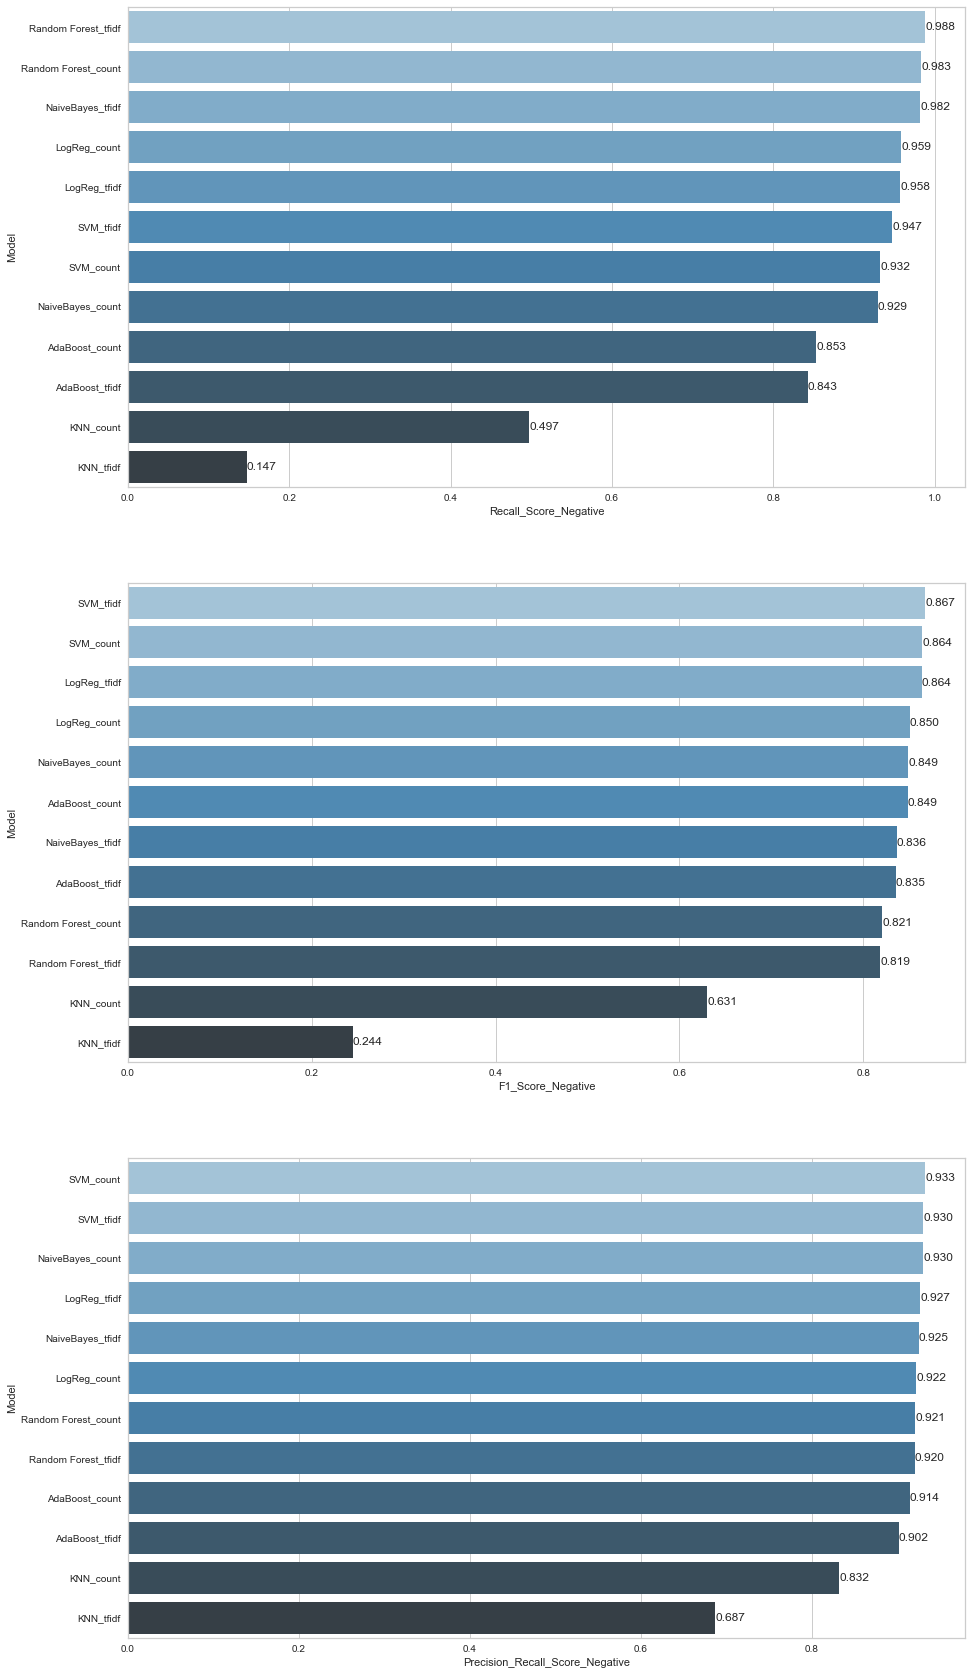

In [102]:
compare = pd.DataFrame({"Model": ["NaiveBayes_count", "LogReg_count", "SVM_count", "KNN_count", "Random Forest_count", 
                                  "AdaBoost_count", "NaiveBayes_tfidf", "LogReg_tfidf", "SVM_tfidf", "KNN_tfidf", 
                                  "Random Forest_tfidf", "AdaBoost_tfidf"],
                        
                        "F1_Score_Negative": [nb_count_f1_neg[0], log_count_f1_neg[0], svc_count_f1_neg[0], knn_count_f1_neg[0],
                                             rf_count_f1_neg[0], ada_count_f1_neg[0], nb_tfidf_f1_neg[0], log_tfidf_f1_neg[0],
                                             svc_tfidf_f1_neg[0], knn_tfidf_f1_neg[0], rf_tfidf_f1_neg[0], ada_tfidf_f1_neg[0]],
                        
                        "Recall_Score_Negative": [nb_count_rec_neg[0], log_count_rec_neg[0], svc_count_rec_neg[0], 
                                                  knn_count_rec_neg[0], rf_count_rec_neg[0], ada_count_rec_neg[0], 
                                                  nb_tfidf_rec_neg[0], log_tfidf_rec_neg[0], svc_tfidf_rec_neg[0], 
                                                  knn_tfidf_rec_neg[0], rf_tfidf_rec_neg[0], ada_tfidf_rec_neg[0]],
                        
                        "Precision_Recall_Score_Negative": [nb_AP_neg, log_AP_neg, svc_AP_neg, knn_AP_neg, rf_AP_neg,
                                                          ada_AP_neg, nb_tfidf_AP_neg, log_tfidf_AP_neg, svc_tfidf_AP_neg,
                                                           knn_tfidf_AP_neg, rf_tfidf_AP_neg, ada_tfidf_AP_neg]})

def labels(ax):
                        
    for p in ax.patches:
        width = p.get_width()                        # get bar length
        ax.text(width,                               # set the text at 1 unit right of the bar
                p.get_y() + p.get_height() / 2,      # get Y coordinate + X coordinate / 2
                '{:1.3f}'.format(width),             # set variable to display, 2 decimals
                ha = 'left',                         # horizontal alignment
                va = 'center')                       # vertical alignment
    
plt.figure(figsize=(15,30))
plt.subplot(311)
compare = compare.sort_values(by="Recall_Score_Negative", ascending=False)
ax=sns.barplot(x="Recall_Score_Negative", y="Model", data=compare, palette="Blues_d")
labels(ax)

plt.subplot(312)
compare = compare.sort_values(by="F1_Score_Negative", ascending=False)
ax=sns.barplot(x="F1_Score_Negative", y="Model", data=compare, palette="Blues_d")
labels(ax)


plt.subplot(313)
compare = compare.sort_values(by="Precision_Recall_Score_Negative", ascending=False)
ax=sns.barplot(x="Precision_Recall_Score_Negative", y="Model", data=compare, palette="Blues_d")
labels(ax)
plt.show();

Hem recall hem de f1 score ile modelin genel performansı yüksek olsun istiyoruz. 

RF recall yüksek ancak f1 scoreları düşük. Önemli olan her kulvarda yani recall, f1 ve modelin genel performansı konusunda bize daha iyi scorelar vereni tercih ediyoruz. 

Ancak bu değerler aynı olduğunda bu durumda ise mesela LogReg ile SVM arasında bir tercih yapmamız gerekiyorsa maliyeti daha düşük olanı tercih ediyoruz.

## For New Tweets, prediction with pipeline


Pipeline ile fit_transform ile fit_predict yapan işlemleri parantez içinde kullanıyorduk. 

Parantez içine ilk yazılanlar fit_transform yapacak yani dönüşüm işlemlerini yapan kısım olacak, ikincisi ise fit_predict yapacak olan yani algoritma olması gerekir.

In [104]:
from sklearn.pipeline import Pipeline

In [105]:
pipe = Pipeline([('tfidf',TfidfVectorizer(preprocessor=cleaning, min_df=3)),('log',LogisticRegression(C=0.4, max_iter=1000))])

In [106]:
pipe.fit(X, y)  # temizlenmemiş hali ile verdik çünkü preprocessor bunu yapacak.

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(min_df=3,
                                 preprocessor=<function cleaning at 0x000001857572BEE0>)),
                ('log', LogisticRegression(C=0.4, max_iter=1000))])

In [107]:
tweet = "it was not the worst flight i have ever been"
tweet = pd.Series(tweet)  # Seriye dönüştürmemiz gerekir aksi takdirde hata alırız.
pipe.predict(tweet)

array(['negative'], dtype=object)

In [108]:
tweet = "didn't enjoy flight"
tweet = pd.Series(tweet)
pipe.predict(tweet)

array(['negative'], dtype=object)

In [109]:
tweet = "it is amazing"
tweet = pd.Series(tweet)
pipe.predict(tweet)

array(['positive'], dtype=object)

In [110]:
tweet = "it isn't amazing"
tweet = pd.Series(tweet)
pipe.predict(tweet)

array(['positive'], dtype=object)

In [111]:
tweet = "don't enjoy flight  at all"
tweet = pd.Series(tweet)
pipe.predict(tweet)

array(['negative'], dtype=object)

In [112]:
tweet = "I don't think I'll ever use American Airlines any more"
tweet = pd.Series(tweet)
pipe.predict(tweet)

array(['negative'], dtype=object)

In [113]:
tweet = "I don't love the flight"
tweet = pd.Series(tweet)
pipe.predict(tweet)

array(['positive'], dtype=object)

In [ ]:
Yukarıda 2 taneyi 

## Collect Words and Counting words

Aşağıda ise temizlenmiş text tek bir cümle gibi birleştiriyorum.

In [114]:
tweets = cleaning_text  # Manuel olarak temizlik yaptığım textim.
tweets

0                                                     said
1             plus youve added commercial experience tacky
2             didnt today must mean need take another trip
3        really aggressive blast obnoxious entertainmen...
4                                     really big bad thing
                               ...                        
14635                   thank got different flight chicago
14636    leaving minute late flight no warning communic...
14637                        please bring american airline
14638    money change flight dont answer phone suggesti...
14639    ppl need know many seat next flight plz put u ...
Name: text, Length: 14640, dtype: object

In [115]:
all_words = " ".join(tweets)

In [116]:
all_words[:100]

'said plus youve added commercial experience tacky didnt today must mean need take another trip reall'

!!! Çok Önemli:

Yukarıda bazı tahminlerde yakalayamadığını gördüğümde bunların neden kaynaklandığını anlamak istiyorum. Bunun için öncelikle corpusum içinde manuel olarak temizlediğim tüm tokenlerimi birleştirip bir text elde ediyorum. Daha sonra bunun içinde tokenlerin kaçar kere geçtiğini counter ile sayıyorum. Ve yanlış tahmin yaptığımız örneklerdeki tokenlere bakıyorum. Bunların corpus içinde az geçtiğini gördüğüm için iyi eğitilemediğinden dolayı yakalayamadığını anlıyorum.

Counter, Corpus içinde geçen tokenleri teker teker sayıyor.

In [117]:
counter = Counter(word_tokenize(all_words))  # tüm cümleyi word tokenlere çevirdim.

In [118]:
counter.most_common()  # corpus içinde geçen tüm tokenlerin sayısını bana verdi.

[('flight', 4524),
 ('not', 1624),
 ('no', 1486),
 ('get', 1374),
 ('hour', 1138),
 ('thanks', 1073),
 ('cancelled', 1048),
 ('u', 994),
 ('service', 987),
 ('time', 946),
 ('customer', 930),
 ('help', 849),
 ('bag', 765),
 ('im', 743),
 ('plane', 724),
 ('amp', 678),
 ('hold', 642),
 ('need', 633),
 ('thank', 602),
 ('one', 580),
 ('still', 578),
 ('cant', 575),
 ('please', 562),
 ('call', 561),
 ('would', 549),
 ('day', 549),
 ('airline', 546),
 ('gate', 541),
 ('delayed', 530),
 ('back', 525),
 ('flightled', 506),
 ('dont', 490),
 ('seat', 480),
 ('got', 480),
 ('phone', 453),
 ('delay', 434),
 ('like', 432),
 ('today', 427),
 ('late', 424),
 ('guy', 423),
 ('agent', 416),
 ('know', 381),
 ('fly', 380),
 ('ticket', 380),
 ('make', 375),
 ('airport', 366),
 ('waiting', 366),
 ('change', 359),
 ('way', 358),
 ('trying', 348),
 ('minute', 345),
 ('go', 336),
 ('great', 335),
 ('ive', 328),
 ('wait', 326),
 ('going', 324),
 ('never', 319),
 ('problem', 312),
 ('min', 309),
 ('tomorrow',

In [119]:
for i in counter.most_common():
    if "enjoy" == i[0]:
        print(i)

('enjoy', 21)


In [120]:
for i in counter.most_common():
    if "love" == i[0]:
        print(i)

('love', 240)


In [121]:
for i in counter.most_common():
    if "like" == i[0]:
        print(i)

('like', 432)


Aşağıda hem love hem de dont geçenlerden labelda negative olanların sayısına baktım. Sayı çok az olduğundan dolayı modelim bunlar ile çalışıp iyi öğrenememiş. 5 token train için yeterli olmamış.

In [122]:
counter = 0
for i,j in enumerate(tweets):
    if "love" in j and "dont" in j and y[i]=="negative":
        counter += 1
print(counter)      

5


In [123]:
counter = 0
for i,j in enumerate(tweets):
    if "like" in j and "dont" in j and y[i]=="negative":
        counter += 1
print(counter)

30


In [124]:
counter = 0
for i,j in enumerate(tweets):
    if "like" in j and "didnt" in j and y[i]=="negative":
        counter += 1
print(counter)

4


In [125]:
counter = 0
for i,j in enumerate(tweets):
    if "amazing" in j and "wasnt" in j and y[i]=="negative":
        counter += 1
print(counter)

0


In [ ]:
counter = 0
for i,j in enumerate(tweets):
    if "amazing" in j and "isnt" in j and y[i]=="negative":
        counter += 1
print(counter)

In [126]:
counter = 0
for i,j in enumerate(tweets):
    if "love" in j and y[i]=="neutral":
        counter += 1
print(counter)

48


## WordCloud - Repetition of Words

## Collect Words

In [127]:
all_words = " ".join(tweets)

In [128]:
all_words[:100]

'said plus youve added commercial experience tacky didnt today must mean need take another trip reall'

## Create Word Cloud

In [130]:
! pip install wordcloud

  Using cached wordcloud-1.8.1-cp39-cp39-win_amd64.whl


In [131]:
from wordcloud import WordCloud

In [132]:
worldcloud = WordCloud(background_color="white", max_words =250)

In [133]:
worldcloud.generate(all_words)  # arka planda en fazla kullanılan 250 kelimeyi oluşturacak.

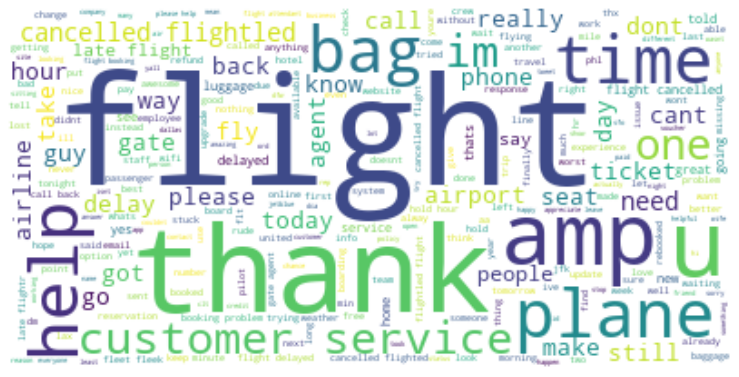

In [134]:
import matplotlib.pyplot as plt
plt.figure(figsize = (13,13))
plt.imshow(worldcloud, interpolation="bilinear",)
plt.axis("off")
plt.show()